## USP - EACH - SIN5007 - Reconhecimento de Padrões - 1º SEM 2020

## Classificação de Modelos cardíacos tridimensionais relacionada à presença ou ausência de cardimiopatia


**Grupo H(8):** <br />
Diego Dedize <br />
Luiz Gustavo Silva <br />
Vagner Mendonça Gonçalves <br />

version 0.2 - 16/04/2020

**Objetivo:** aplicar modelos de classificação  e avaliar os resultados obtidos em um dataset composto por vetores de características extraídas de modelos 3D reconstruídos a partir de exames de Ressonancia Magnética Cardíaca (RMC).

**Cardiomiopatia:** quadro clínico dado por uma anormalidade no miocárdio (estrutura muscular do coração) (KUMAR et al., 2010 apud BERGAMASCO, 2018).

**Fonte dos dados:** Dataset disponibilizado pelo Laboratório de Aplicações de Informática em Saúde (LApIS) - EACH/USP, coordenado pela Profa. Dra. Fátima L. S. Nunes.

**Referências:** <br />
BERGAMASCO, Leila Cristina Carneiro. Recuperação de imagens cardíacas tridimensionais por conteúdo. 2013. 134 f. Dissertação (Mestrado em Ciências) - Programa de Pós-graduação em Sistemas de Informação, Escola de Artes, Ciências e Humanidades, Universidade de São Paulo, São Paulo, 2013. 

BERGAMASCO, Leila Cristina Carneiro. Recuperação de objetos médicos 3D utilizando harmônicos esféricos e redes de fluxo. 2018. 181 f. Tese (Doutorado em Ciências) - Escola Politécnica, Departamento de Engenharia da Computação e Sistemas Digitais, Universidade de São Paulo, São Paulo, 2018.

KUMAR, V.; ABBAS, A. K.; FAUSTO, N.; ASTER, J. C.. Robbins & Cotran – Patologia: Bases Patológicas das Doenças. 8 ed. Rio de Janeiro: Elsevier, 2010.


# Importanto bibliotecas importantes

In [1]:
%matplotlib inline
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier


import statsmodels.stats.api as sms
from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier

#import pandas_profiling

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

# Importando arquivos

In [ ]:
df_lu = pd.read_csv("../ARQUIVOS_FINAIS/CMCT_20200503.csv")
df_lu.head(3)

#Joga o target para ultima posicao
df_1_ = df_lu.iloc[:,:5]


df_2_ = df_lu.iloc[:,6:]
df_3_ = pd.concat([df_1_,df_2_],axis=1)

df_targ = df_lu[['TARGET']]

df_4_ = pd.concat([df_3_,df_targ],axis=1)

df_lu = df_4_
df_lu.head()

In [ ]:

#profile = ProfileReport(df_lu, title='Profiling DataFrame',minimal=True,html={'style':{'full_width':True}})
#profile.to_notebook_iframe()

### Verifica missings

In [ ]:
#Todas as variaveis estão preenchidas

#Verifica % de missing por coluna
dados_vazios = (df_lu.isnull().sum()/len(df_lu['id']))*100
dados_vazios.head(10)

#msno.bar(df_lu)

### Neste ponto traduzimos as classes de acordo com os parametros indicados na apresentação 1
Registros de 1 a 101 a classe é NORMAL <br />
Registros de 102 a 218 a classe é CARDIMIOPATIA DILATADA <br />
Registros de 219 a 401 a classe é  CARTIDIOPATIA HIPERTRÓFICA <br />

In [ ]:
for ind, row in df_lu.iterrows():
    if (df_lu.loc[ind,'TARGET']==0): df_lu.loc[ind,'class_desc'] = 'normal'
    if (df_lu.loc[ind,'TARGET']==1): df_lu.loc[ind,'class_desc'] = 'CMH'
    if (df_lu.loc[ind,'TARGET']==2): df_lu.loc[ind,'class_desc'] = 'CMD'

#Verifica a quantidade de cada classe
df_lu['class_desc'].value_counts()

#df_pac.dtypes
#df_lu.head(3)

In [ ]:
#Sabemos que sexo é uma variavel importante (conforme pesquisa Fonte), portanto esse 
#desbalanceamento pode ser um problema. Vamos acompanhar ao longo do processo
TOTAL = df_lu.sexo.value_counts()
total_M = TOTAL[1]
total_F = TOTAL[0]

valores = [total_M,total_F]
series = ['Feminino','Masculino']

plt.axis('equal')
plt.rcParams.update({'font.size':14})
plt.rcParams["figure.figsize"] = [5,4]

plt.pie(valores,labels=series,autopct='%1.1f%%',
        explode=(0,0.1),shadow = True,startangle=90,)

plt.title("Participação por sexo",size=14,weight='demibold')
plt.show()

print('Valores absolutos:')
df_lu['sexo'].value_counts()

# Definição das classes utilizadas dataset

#### Dado que o numero de observações entre "sem cardiomiopatia" e "com cardimiopatia (em caso de soma CDM+CMH") ficaria desbalanceado, optamos por trabalhar com as classes nomal e CMD

In [ ]:
#Verifica a quantidade de cada classe
df_final = df_lu
#df_final['class_desc'].value_counts()

#Determinando quais classes uremos utilizar
df_final_1 = df_final[df_final['TARGET']!=1]

df_final_3 = df_final_1

df_final_1['TARGET'].value_counts()

### Deleta campos que não vamos utilizar

In [ ]:
df_final_4 = df_final_3.drop(['class_desc'],axis = 1)
df_final_4 = df_final_4.drop(['id'],axis = 1)
df_final_4.head(3)

In [ ]:
#exporta dataset final
df_final_4.to_csv("../RESULTADOS/df_final_20200510.csv", index = False)

# Inicio após exportação

In [ ]:
df_final_5 = pd.read_csv("../RESULTADOS/df_final_20200510.csv")
#pd.set_option('display.max_columns',329)

#df_final_5.shape
#df_final_5.head(3)


#Verifica correlação
# sns.heatmap(df_final_5.corr(), annot = True, fmt = '.2f', cmap='Blues')
# plt.title('Correlação features')
# plt.show()

#AJUSTA O DATASET QUE IRÁ UTILIZAR PARA FAZER O PCA
pca_1 = df_final_5
pca_1.head(3)

# Seleção de caracteristicas por meio de PCA

Neste ponto fizemos alguns testes para verificar qual é o melhor número de componentes principais que poderiamos utilizar de forma que garantissemos a maior taxa de variação explicada acumulada e tivessemos uma redução de dimensionalidade significativa.
Efetuamos os seguintes passos:
- 1 Visualização em 2d (2 componentes principais) e apuramos a taxa de variação explicada;
- 2 Visualização em 3d (3 componentes principais) e apuramos a taxa de variação explicada;
- 3 Verificação de numeros de componentes principais x variância explicada acumulada. Neste ponto conseguimos determinar qual é o    numero de componentes que iremos utilizar em nosso trabalho.

In [ ]:
# Separando as fetures por abordagem (define features por abordagem e seta o df da abordagem atual)
abordagem_1 = pca_1.columns[0:-1]
#abordagem_2 = ['idade', 'sexo','volume','massa','HoughEndo','HoughEpi','HoughParede']

##abordagem 3 
#abordagem_3 = ['idade', 'sexo','volume','massa']

#Utiliza a abordagem para selecionar as features
abordagem = abordagem_1
feat = abordagem

colunas = feat
df_atual = pca_1.loc[:, colunas]
df_atual = pd.concat([df_atual,pca_1['TARGET']],axis=1)
df_atual.head(3)

In [ ]:
#Aplica o PCA para todo o dataset
X = pca_1.loc[:, feat].values

# Separa target
y = pca_1.loc[:,['TARGET']].values

# Standardizing the features
X = StandardScaler().fit_transform(X)

#dados normalizados
pca_1_normal = pd.DataFrame(data=X,columns = feat)

pca_1_y =  pd.DataFrame(data=y,columns = ['TARGET'])

#Faz de/para para gráfico
pca_1_y['TARGET'].replace(0,'Normal',inplace=True)
pca_1_y['TARGET'].replace(2,'CMD',inplace=True)

#pca_1_normal.tail(3)
#pca_1_y.tail(3)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

finalDf = pd.concat([principalDf, pca_1_y], axis = 1)

fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Pc 1', fontsize = 15)
ax.set_ylabel('Pc 2', fontsize = 15)
ax.set_title('PCA com 2 componentes principais', fontsize = 15)

targets = ['Normal','CMD']
colors = ['g','r']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['TARGET'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 60)
ax.legend(targets)
ax.grid()

finalDf.head(3)


total_taxa_explicada=0
for i in range(0,len(pca.explained_variance_ratio_)):
    total_taxa_explicada += pca.explained_variance_ratio_[i]

print("APLICANDO O PCA PARA 2 COMPONENTES:")
print(f'Variação explicada total_taxa_explicada: {round(total_taxa_explicada*100,2)}%')
print()

In [ ]:
#Testa com 3 componentes
X = pca_1.loc[:, feat].values

# Separa target
y = pca_1.loc[:,['TARGET']].values

# Standardizing the features
X = StandardScaler().fit_transform(X)


pca_3 = PCA(n_components=3)
principalComponents_3 = pca_3.fit_transform(X)
principalDf_3 = pd.DataFrame(data = principalComponents_3
             , columns = ['pc1', 'pc2', 'p3'])

finalDf_3 = pd.concat([principalDf_3, pca_1_y], axis = 1)
#finalDf_3.head(3)

x = []
y = []
z = []
for ls in principalComponents_3:
    x.append(ls[0])
    y.append(ls[1])
    z.append(ls[2])

colors = ['b', 'y', 'r', 'c', 'm', 'g', 'k', 'w']
aux = 0

classes = pca_1['TARGET'].value_counts()

fig = plt.figure()
ax = Axes3D(fig)

for c in classes.index:
    if c == 0:
        lb = 'Normal'
    else:
        lb = 'CMD'
    nodes = np.where(y == c)
    ax.scatter(z, x, y, s=50, color = colors[aux], label = lb)
    aux = aux + 1
    


total_taxa_explicada=0
for i in range(0,len(pca_3.explained_variance_ratio_)):
    total_taxa_explicada += pca_3.explained_variance_ratio_[i]

print("APLICANDO O PCA PARA 3 COMPONENTES:")
print(f'Variação explicada total_taxa_explicada: {round(total_taxa_explicada*100,2)}%')
print()

plt.legend()
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.xticks(color='k', size=10)
plt.yticks(color='k', size=10)
plt.show(True)

### Note que a partir de 100 componentes atingimos 100% de variação explicada dos dados

In [ ]:
pca = PCA().fit(X)

ncomp = np.arange(1, np.shape(X)[0]+1)

plt.figure(figsize=(8,5))
plt.plot(ncomp, np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.xlabel('numero de componentes', fontsize=15)
plt.ylabel('variância explicada acumulada', fontsize=15);
plt.xticks(color='k', size=12)
plt.yticks(color='k', size=12)
plt.grid(True)
plt.show(True)

In [ ]:
# Verificando a influência dos atributos originais na composição dos elemntos do PCA
pca = PCA()
pca_result = pca.fit_transform(X)
var_exp = pca.explained_variance_ratio_

importances = var_exp
indices = np.argsort(importances)
attributes_rank = []

for i in indices:
    attributes_rank.append(pca_1.columns[i])


importancia =[]
for i in range(0,len(importances)):
    importancia.append(round(importances[i]*100,2))

DFimportancia = pd.DataFrame(data = importancia,columns=['importancia'])
DFimportancia.head(10)


attributes_rank.reverse()
feature = pd.DataFrame(data = attributes_rank,columns=['feature'])
#feature.head(3)

pca_importantes = pd.concat([feature, DFimportancia], axis = 1)
#pca_importantes.head()


#print("Selecionando features com importância acima de 2%")
#pca_importantes[pca_importantes['importancia']>0.0]
pca_importantes.loc[(pca_importantes['importancia']) > 0.18]

# plt.figure(figsize=(10, 30))
# plt.title('Feature Importances')
# plt.tight_layout()
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), attributes_rank, fontsize=20)
# plt.xlabel('Relative Importance',fontsize=20)
# plt.xticks(color='k', size=8)
# plt.yticks(color='k', size=8)
# plt.xlim([0.0, 0.25])
# plt.show()

In [ ]:
#Exporta dataset selecionado pela importancia do PCA:
colunas_pca = pca_importantes.loc[(pca_importantes['importancia']) > 0.18]
colunas_pca = colunas_pca['feature'].values

df_pca_features_importances = df_final_5[colunas_pca]


df_pca_features_importances = pd.concat([df_pca_features_importances,df_final_5['TARGET']],axis=1)


#exporta dataset final
df_pca_features_importances.to_csv("../RESULTADOS/df_pca_features_importances_20200510.csv", index = False)

df_pca_features_importances.head(3)

In [ ]:
#TESTA COM N QUANTIDADES DE COMPONENTES PRINCIPAIS

#Faz loop para nomear coluna de atributos
n=53
coluna_pca = []
for i in range(0,n):
     coluna_pca.append('pc' + str(i+1))


pca_n = PCA(n_components=n)
principalComponents_n = pca_n.fit_transform(X)
principalDf_n = pd.DataFrame(data = principalComponents_n
             , columns = coluna_pca)
finalDf_n = pd.concat([principalDf_n, pca_1_y], axis = 1)
finalDf_n.head(3)


total_taxa_explicada=0
for i in range(0,len(pca_n.explained_variance_ratio_)):
    total_taxa_explicada += pca_n.explained_variance_ratio_[i]

print(f'APLICANDO O PCA PARA {n}  COMPONENTES:')
print(f'Variação explicada total_taxa_explicada: {round(total_taxa_explicada*100,2)}%')
print()

In [ ]:

#Faz de/para para ficar no mesmo padrão
finalDf_n['TARGET'].replace('Normal',0,inplace=True)
finalDf_n['TARGET'].replace('CMD',2,inplace=True)

#exporta dataset final
finalDf_n.to_csv("../RESULTADOS/df_pca_pc53_20200510.csv", index = False)

finalDf_n.head(3)

## Conclusão PCA

Quando utilizamos até 3 componentes principais não conseguimos ter uma boa separação das classes, contudo quando verificamos a contribuição de cada caracteristica para a separação é possivel notar que 53 caracteristicas é o suficiente para representar mais de 90% do dataset origial que continha 330 features inicialmente.

# Seleção de caracteristicas por meio de algoritmos de seleção

Neste ponto testamos alguns algoritmos de redução de dimensionalidade. Dado que o resultado do PCA consinste em juntar caracteristicas para formar novas caracteristicas, entendemos que para ter uma aproximação do resultado da variação explicada acima, temos que no minimo considerar o mesmo "n".

In [ ]:
#Total atributos menos o target
df_atual = pd.read_csv("../RESULTADOS/df_final_20200510.csv")
total_atributos = len(df_atual.columns) -1

#Para a seleção utilizaremos noss "D" como a raiz quadrada do nosso total
#D_caracteristicas = int(np.sqrt(total_atributos))
n=53
D_caracteristicas = n

print(f'TOTAL CARACTERISTICAS: {total_atributos}')
print(f'CARACTERISTICAS UTILIZADAS NA SELEÇÃO DE FEATURES: {D_caracteristicas}')

# Select Kbest
## Tipo Filtro

O SelectKBest remove todas as features, exceto os recursos de pontuação mais alta para isso conta com aseleção univariada. Ela funciona selecionando os melhores recursos com base em testes estatísticos univariados. Pode ser visto como uma etapa de pré-processamento para um estimador (tipo filtro).

Seus métodos para classificação são: chi2, f_classif, mutual_info_classif

Os métodos baseados no teste F estimam o grau de dependência linear entre duas variáveis aleatórias. Por outro lado, os métodos de informação mútua podem capturar qualquer tipo de dependência estatística, mas, sendo não paramétricos, exigem mais amostras para uma estimativa 

In [ ]:
df_atual.head(3)
#df_atual.iloc[217:2]
#217, 2

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif


f_classif = SelectKBest(score_func = f_classif,k=D_caracteristicas)
#f_classif = SelectKBest(mutual_info_classif,k=D_caracteristicas)



x = df_atual.drop(['TARGET'],axis=1)
y = df_atual['TARGET']


fit = f_classif.fit(x,y)


features = fit.transform(x)
#print(features)


colunas = fit.get_support(indices=True)
df_novo = df_atual.iloc[:,colunas]
df_novo


df_novo_c_target = pd.concat([df_novo,df_atual['TARGET']],axis=1)
df_novo_c_target.head(3)

In [ ]:
#exporta dataset final
#df_novo_c_target.to_csv("../RESULTADOS/df_kbest_fclassif_20200510.csv", index = False)
#df_novo_c_target.to_csv("../RESULTADOS/df_kbest_mutual_info_classif_20200522.csv", index = False)

#exporta KBEST sem idade (TESTE importancia caracteristicas)
#df_novo_c_target = df_novo_c_target.drop(['idade'],axis=1)
#df_novo_c_target.to_csv("../RESULTADOS/df_kbest_fclassif_sem_idade_20200522.csv", index = False)
df_novo_c_target.head()


# Features Importances (com RandomForest)
# Tipo embutido

Para este caso escolhemos o classificador e selecionamos as caracteristicas manualmente de acordo com a importancia dada pelo classificador em relação à classe alvo.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

x = df_atual.drop(['TARGET'],axis=1)
y = df_atual['TARGET']

# Treinando o modelo na base inteira
model  = RandomForestClassifier()
model.fit(x, y)

# Verificando a importância decada feature
#model.feature_importances_


feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

feat_select = feature_importances[feature_importances['importance']>0.004]


pd.set_option('display.max_rows',328)
feature_importances


print(f'TOTAL CARACTERISTICAS SELECIONADAS: {len(feat_select)}')

In [ ]:
df_novo_c_target = pd.concat([df_atual.loc[:,feat_select.index],df_atual['TARGET']],axis=1)
df_atual.loc[:,feat_select.index].head(3)

In [ ]:
#exporta dataset final
df_novo_c_target.head(3)
df_novo_c_target.to_csv("../RESULTADOS/df_randon_forest_importances_20200510.csv", index = False)

# RFE: Recursive feature elimination
## Tipo Camada
A eliminação recursiva de recursos (RFE) seleciona subconjuntos recursivamente, considerando conjuntos cada vez menores de features. Primeiro, o estimador é treinado no conjunto inicial de recursos e a importância de cada feature é obtida por meio de um atributo "coef_" ou através de um atributo "feature_importances_". Em seguida, os recursos menos importantes são removidos do conjunto atual de recursos. Esse procedimento é repetido recursivamente no conjunto removido até que o número desejado de recursos a serem selecionados seja finalmente atingido.

O RFECV executa o RFE em um loop de validação cruzada para encontrar o número ideal de recursos.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE



x = df_atual.drop(['TARGET'],axis=1)
y = df_atual['TARGET']

model = LogisticRegression(max_iter=80000)

rfe = RFE(model,D_caracteristicas)

fit = rfe.fit(x,y)


features = fit.get_support(indices=True)


df_novo_c_target = pd.concat([df_atual.iloc[:,features],df_atual['TARGET']],axis=1)
df_atual.iloc[:,features].head(3)

In [ ]:
#exporta dataset final
df_novo_c_target.to_csv("../RESULTADOS/df_RFE_20200510.csv", index = False)

# Sequential Forward Selection (SFS)
## Tipo: Heurístico
A cada iteração novas
características são adicionadas ao subconjunto
corrente

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier

#Método de distancia utilizada
knn = KNeighborsClassifier(n_neighbors=2)
#knn = KNeighborsClassifier(n_neighbors=5)
#knn = KNeighborsClassifier(n_neighbors=15)
#knn = KNeighborsClassifier(n_neighbors=30)
#knn = KNeighborsClassifier(n_neighbors=90)
#knn = KNeighborsClassifier(n_neighbors=100)
#knn = KNeighborsClassifier(n_neighbors=180)


x = df_atual.drop(['TARGET'],axis=1)
y = df_atual['TARGET']

sfs1 = SFS(knn, 
           k_features=D_caracteristicas, 
           forward=True, 
           floating=False, 
           verbose=0, # 0,1 ou 2 (Exibe a saida da do algoritmo)
           scoring='accuracy',
           cv=10,
           n_jobs=-1)

#PARAMETROS SELECIONADOS PARA OS ARQUIVOS DE TESTE,30,90,180:
#CV 0 E VIZINHO n_neighbors=(30,90,180) e floating = False


sfs1 = sfs1.fit(x, y)
#sfs1.k_feature_names_
sfs1.k_score_

In [ ]:
#CV 10 E VIZINHO   05  e floating = False = 79,26 #EXPORTADO PARA UTILIZAÇÃO

#CV 0 E VIZINHO    15  e floating = False = 81,56 #EXPORTADO PARA UTILIZAÇÃO
#CV 10 E VIZINHO   15  e floating = False = 80,67 #EXPORTADO PARA UTILIZAÇÃO

#CV 0 E VIZINHO    30  e floating = False = 76,03 #EXPORTADO PARA UTILIZAÇÃO
#CV 10 E VIZINHO   30  e floating = False = 74,61

#CV  0 E VIZINHO   90  e floating = False = 73,27 #EXPORTADO PARA UTILIZAÇÃO
#CV 10 E VIZINHO   90  e floating = False = 73,24

#CV  0 E VIZINHO  100  e floating = False = 71,88
#CV 10 E VIZINHO  100  e floating = False = 73,24

#CV  0 E VIZINHO  180  e floating = False = 73,73 #EXPORTADO PARA UTILIZAÇÃO
#CV 10 E VIZINHO  180  e floating = False = 74,71 #EXPORTADO PARA UTILIZAÇÃO


In [ ]:
df_novo_c_target = pd.concat([df_atual.iloc[:,list(sfs1.k_feature_idx_)],df_atual['TARGET']],axis=1)
df_atual.iloc[:,list(sfs1.k_feature_idx_)].head(3)
#df_novo_c_target

In [ ]:
#exporta dataset final
#df_novo_c_target.to_csv("../RESULTADOS/df_SFS_20200510.csv", index = False)

#TESTE COM MODIFICANDO QUANTIDADE DE VIZINHOS
df_novo_c_target.to_csv("../RESULTADOS/df_SFS_20200523_N5_CV10.csv", index = False)
#df_novo_c_target.to_csv("../RESULTADOS/df_SFS_20200523_N90.csv", index = False)
#df_novo_c_target.to_csv("../RESULTADOS/df_SFS_20200523_N180.csv", index = False)
#df_novo_c_target.to_csv("../RESULTADOS/df_SFS_20200523_N15_CV10.csv", index = False)
#df_novo_c_target.to_csv("../RESULTADOS/df_SFS_20200523_N15_CV00.csv", index = False)
#df_novo_c_target.to_csv("../RESULTADOS/df_SFS_20200523_N180_CV10.csv", index = False)

# Sequential Forward Floating Selection (SFFS)
## Tipo: Heurístico
A cada iteração novas
características são adicionadas ao subconjunto
corrente

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier

#Método de distancia utilizada
knn = KNeighborsClassifier(n_neighbors=5)
#knn = KNeighborsClassifier(n_neighbors=15)
#knn = KNeighborsClassifier(n_neighbors=30)
#knn = KNeighborsClassifier(n_neighbors=90)


x = df_atual.drop(['TARGET'],axis=1)
y = df_atual['TARGET']

sffs = SFS(knn, 
           k_features=D_caracteristicas, 
           forward=True, 
           floating=True, 
           verbose=0,
           #verbose=2,(Exibe a saida da do algoritmo)
           scoring='accuracy',
           cv=10,
           n_jobs=-1)

sffs = sffs.fit(x, y)
sffs.k_score_

In [ ]:
#CV 10 E VIZINHO   5  e floating = True =  77,38 #EXPORTADO PARA UTILIZAÇÃO

#CV 0 E VIZINHO    15  e floating = True =  81,56 #EXPORTADO PARA UTILIZAÇÃO
#CV 10 E VIZINHO   15  e floating = True =  77,38 #EXPORTADO PARA UTILIZAÇÃO

#CV 0 E VIZINHO    30  e floating = True =  78,80 #EXPORTADO PARA UTILIZAÇÃO
#CV 10 E VIZINHO   30  e floating = True =  74,63 #EXPORTADO PARA UTILIZAÇÃO

#CV  0 E VIZINHO   90  e floating = True =  76,03 #EXPORTADO PARA UTILIZAÇÃO
#CV 10 E VIZINHO   90  e floating = True =  74,19 #EXPORTADO PARA UTILIZAÇÃO


In [ ]:
df_novo_c_target = pd.concat([df_atual.iloc[:,list(sfs1.k_feature_idx_)],df_atual['TARGET']],axis=1)
df_atual.iloc[:,list(sfs1.k_feature_idx_)].head(3)
#df_novo_c_target

In [ ]:
#exporta dataset final
#TESTE COM MODIFICANDO QUANTIDADE DE VIZINHOS
df_novo_c_target.to_csv("../RESULTADOS/df_SFFS_20200523_N5_CV10.csv", index = False)
#df_novo_c_target.to_csv("../RESULTADOS/df_SFFS_20200523_N15_CV00.csv", index = False)
#df_novo_c_target.to_csv("../RESULTADOS/df_SFFS_20200523_N15_CV10.csv", index = False)
#df_novo_c_target.to_csv("../RESULTADOS/df_SFFS_20200523_N30_CV00.csv", index = False)
#df_novo_c_target.to_csv("../RESULTADOS/df_SFFS_20200523_N30_CV10.csv", index = False)
#df_novo_c_target.to_csv("../RESULTADOS/df_SFFS_20200523_N90_CV00.csv", index = False)
#df_novo_c_target.to_csv("../RESULTADOS/df_SFFS_20200523_N90_CV10.csv", index = False)

# Sequential Backward Selection (SBS)
## Tipo: Heurístico
A cada iteração
características são deletadas do subconjunto
corrente

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier


#Método de distancia utilizada
knn = KNeighborsClassifier(n_neighbors=30)

x = df_atual.drop(['TARGET'],axis=1)
y = df_atual['TARGET']

# Sequential Backward Selection
sbs = SFS(knn, 
          k_features=D_caracteristicas, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=4,
          n_jobs=-1)
sbs = sbs.fit(x, y)

sbs.k_feature_names_
#sbs.k_score_

In [ ]:
df_novo_c_target = pd.concat([df_atual.iloc[:,list(sbs.k_feature_idx_)],df_atual['TARGET']],axis=1)
df_atual.iloc[:,list(sbs.k_feature_idx_)].head(3)

In [ ]:
#df_atual.iloc[:,list(sbs.k_feature_idx_)].columns
#exporta dataset final
df_novo_c_target.to_csv("../RESULTADOS/df_SBS_20200510.csv", index = False)
#df_novo_c_target.head(3)

# K Folds

In [ ]:
df_atual['TARGET'].value_counts()

In [ ]:
X = df_atual.drop(['TARGET'],axis=1).values
y = df_atual['TARGET']

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

StratifiedKFold(n_splits=10, random_state=None, shuffle=True)
i=0
for train_index, test_index in skf.split(X,y):   
    
    i=i+1
    df_treinoy = df_atual.iloc[test_index]
    k_group = df_treinoy['TARGET'].value_counts()
    
    #Sem Anomalia
    NORMAL = k_group[0]
    
    #Cardimiopatia Dilatada
    CMD = k_group[2]

    #TOTAL
    total = NORMAL + CMD

    part_NORMAL = round(NORMAL/(NORMAL+CMD) * 100, 2)
    part_CMD = round(CMD/(NORMAL+CMD) * 100, 2)

    print(f'k = {i}: NORMAL: {NORMAL}| CMD: {CMD}| Total: {total}|',f'NORMAL: {part_NORMAL}% CMD: {part_CMD}%')
    print()

# Distribuição dos Dados

In [ ]:
# feature	importancia
# 0	idade	12.85
# 1	sexo	11.03
# 2	volume	8.58
# 3	massa	8.11
# 4	EDLEndo01	5.24
# 5	EDLEndo02	4.54
# 6	EDLEndo03	3.26
# 7	EDLEndo04	2.86
# 8	EDLEndo05	2.72
# 9	EDLEndo06	2.42
# 10	EDLEndo07	2.09

In [ ]:

df_nb = pd.read_csv("../RESULTADOS/df_final_20200510.csv") 
#IDADE
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
media= df_nb.idade.mean()
mediana= df_nb.idade.median()
inf= media - df_nb.idade.std()
sup= media + df_nb.idade.std()
df_nb.idade.plot.density()
plt.ylabel('Frequencia')
plt.xlabel('idade')


plt.axvline(media,color='C2')
plt.axvline(mediana,color='C1',linestyle='--')
plt.axvline(inf,color='C1',linestyle=':')
plt.axvline(sup,color='C1',linestyle=':')
plt.show()

#VOLUME
plt.figure(figsize=(20,10))
plt.subplot(2,2,2)
media= df_nb.volume.mean()
mediana= df_nb.volume.median()
inf= media - df_nb.volume.std()
sup= media + df_nb.volume.std()
df_nb.volume.plot.density()
plt.ylabel('Frequencia')
plt.xlabel('volume')


plt.axvline(media,color='C2')
plt.axvline(mediana,color='C1',linestyle='--')
plt.axvline(inf,color='C1',linestyle=':')
plt.axvline(sup,color='C1',linestyle=':')
plt.show()

#MASSA
plt.figure(figsize=(20,10))
plt.subplot(2,2,3)
media= df_nb.massa.mean()
mediana= df_nb.massa.median()
inf= media - df_nb.massa.std()
sup= media + df_nb.massa.std()
df_nb.massa.plot.density()
plt.ylabel('Frequencia')
plt.xlabel('massa')


plt.axvline(media,color='C2')
plt.axvline(mediana,color='C1',linestyle='--')
plt.axvline(inf,color='C1',linestyle=':')
plt.axvline(sup,color='C1',linestyle=':')
plt.show()

#EDLENDO
plt.figure(figsize=(20,10))
plt.subplot(2,2,4)
media= df_nb.EDLEndo01.mean()
mediana= df_nb.EDLEndo01.median()
inf= media - df_nb.EDLEndo01.std()
sup= media + df_nb.EDLEndo01.std()
df_nb.EDLEndo01.plot.density()
plt.ylabel('Frequencia')
plt.xlabel('EDLEndo01')


plt.axvline(media,color='C2')
plt.axvline(mediana,color='C1',linestyle='--')
plt.axvline(inf,color='C1',linestyle=':')
plt.axvline(sup,color='C1',linestyle=':')
plt.show()

In [ ]:
df_nb = pd.read_csv("../RESULTADOS/df_pca_pc53_20200510.csv") 

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
media= float(df_nb.pc1.mean())
mediana= float(df_nb.pc1.median())
inf= float(media - df_nb.pc1.std())
sup= float(media + df_nb.pc1.std())
df_nb.pc1.plot.density()
plt.ylabel('Frequencia')
plt.xlabel('pc1')


plt.axvline(media,color='C2')
plt.axvline(mediana,color='C1',linestyle='--')
plt.axvline(inf,color='C1',linestyle=':')
plt.axvline(sup,color='C1',linestyle=':')
plt.show()

##pc2
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
media= float(df_nb.pc2.mean())
mediana= float(df_nb.pc2.median())
inf= float(media - df_nb.pc2.std())
sup= float(media + df_nb.pc2.std())
df_nb.pc2.plot.density()
plt.ylabel('Frequencia')
plt.xlabel('pc1')


plt.axvline(media,color='C2')
plt.axvline(mediana,color='C1',linestyle='--')
plt.axvline(inf,color='C1',linestyle=':')
plt.axvline(sup,color='C1',linestyle=':')
plt.show()

##pc3
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
media= float(df_nb.pc3.mean())
mediana= float(df_nb.pc3.median())
inf= float(media - df_nb.pc3.std())
sup= float(media + df_nb.pc3.std())
df_nb.pc3.plot.density()
plt.ylabel('Frequencia')
plt.xlabel('pc1')


plt.axvline(media,color='C2')
plt.axvline(mediana,color='C1',linestyle='--')
plt.axvline(inf,color='C1',linestyle=':')
plt.axvline(sup,color='C1',linestyle=':')
plt.show()


##pc4
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
media= float(df_nb.pc4.mean())
mediana= float(df_nb.pc4.median())
inf= float(media - df_nb.pc4.std())
sup= float(media + df_nb.pc4.std())
df_nb.pc4.plot.density()
plt.ylabel('Frequencia')
plt.xlabel('pc1')


plt.axvline(media,color='C2')
plt.axvline(mediana,color='C1',linestyle='--')
plt.axvline(inf,color='C1',linestyle=':')
plt.axvline(sup,color='C1',linestyle=':')
plt.show()



# APLICA MODELOS AO DATASET

In [2]:
def Separa_dados(dataset_testado,k_qtd):

    #DEFINE QUAL ARQUIVO SERÁ APLICADO O MODELO
    if dataset_testado == 'COMPLETO':
        df_nb = pd.read_csv("../RESULTADOS/df_final_20200510.csv") #COMPLETO
    
    if dataset_testado == 'PCA':
        df_nb = pd.read_csv("../RESULTADOS/df_pca_pc53_20200510.csv") #PCA
    
    if dataset_testado == 'PCA_IMPORTANCES':
        df_nb = pd.read_csv("../RESULTADOS/df_pca_features_importances_20200510.csv") #PCA IMPORTANCES

    if dataset_testado == 'KBEST':
        df_nb = pd.read_csv("../RESULTADOS/df_kbest_fclassif_20200510.csv") #KBEST f_classif

    if dataset_testado == 'KBEST_2':
        df_nb = pd.read_csv("../RESULTADOS/df_kbest_mutual_info_classif_20200522.csv") #KBEST mutual_info_classif

    if dataset_testado == 'RFE':
        df_nb = pd.read_csv("../RESULTADOS/df_RFE_20200510.csv") #RFE
    
    if dataset_testado == 'RANDON_FOREST_IMPORTANTES':
        df_nb = pd.read_csv("../RESULTADOS/df_randon_forest_importances_20200510.csv") #RANDON FOREST

    if dataset_testado == 'SBS':
        df_nb = pd.read_csv("../RESULTADOS/df_SBS_20200510.csv") #RANDON FOREST

    if dataset_testado == 'KBEST_S_IDADE':
        df_nb = pd.read_csv("../RESULTADOS/df_kbest_fclassif_sem_idade_20200522.csv") #KBEST F CLASSIF SEM IDADE

    #TESTE COM SFS
    if dataset_testado == 'SFS_5_CV10':
        df_nb = pd.read_csv("../RESULTADOS/df_SFS_20200523_N5_CV10.csv") #SFS 15 VIZINHOS

    if dataset_testado == 'SFS_15_CV00':
        df_nb = pd.read_csv("../RESULTADOS/df_SFS_20200523_N15_CV00.csv") #SFS 15 VIZINHOS

    if dataset_testado == 'SFS_15_CV10':
        df_nb = pd.read_csv("../RESULTADOS/df_SFS_20200523_N15_CV10.csv") #SFS 15 VIZINHOS

    if dataset_testado == 'SFS_30_CV00':
        df_nb = pd.read_csv("../RESULTADOS/df_SFS_20200510_N30_CV00.csv") #SFS 30 VIZINHOS

    if dataset_testado == 'SFS_90_CV00':
        df_nb = pd.read_csv("../RESULTADOS/df_SFS_20200523_N90_CV00.csv") #SFS 90 VIZINHOS

    if dataset_testado == 'SFS_180_CV00':
        df_nb = pd.read_csv("../RESULTADOS/df_SFS_20200523_N180_CV00.csv") #SFS 180 VIZINHOS

    if dataset_testado == 'SFS_180_CV10':
        df_nb = pd.read_csv("../RESULTADOS/df_SFS_20200523_N180_CV10.csv") #SFS 180 VIZINHOS


    #TESTE COM SFFS
    if dataset_testado == 'SFFS_5_CV10':
        df_nb = pd.read_csv("../RESULTADOS/df_SFFS_20200523_N15_CV10.csv") #SFFS 15 VIZINHOS

    if dataset_testado == 'SFFS_15_CV00':
        df_nb = pd.read_csv("../RESULTADOS/df_SFFS_20200523_N15_CV00.csv") #SFFS 15 VIZINHOS

    if dataset_testado == 'SFFS_15_CV10':
        df_nb = pd.read_csv("../RESULTADOS/df_SFFS_20200523_N15_CV10.csv") #SFFS 15 VIZINHOS

    if dataset_testado == 'SFFS_30_CV00':
        df_nb = pd.read_csv("../RESULTADOS/df_SFFS_20200523_N30_CV00.csv") #SFFS 30 VIZINHOS

    if dataset_testado == 'SFFS_30_CV10':
        df_nb = pd.read_csv("../RESULTADOS/df_SFFS_20200523_N30_CV10.csv") #SFFS 30 VIZINHOS       

    if dataset_testado == 'SFFS_90_CV00':
        df_nb = pd.read_csv("../RESULTADOS/df_SFFS_20200523_N90_CV00.csv") #SFFS 30 VIZINHOS  

    if dataset_testado == 'SFFS_90_CV10':
        df_nb = pd.read_csv("../RESULTADOS/df_SFFS_20200523_N90_CV10.csv") #SFFS 30 VIZINHOS 

    # Separando a coluna Target das características
    dfx1 = df_nb.drop('TARGET', axis=1)
    masc = df_nb['TARGET'] == 2
    df_nb.loc[masc, 'TARGET'] = 1
    Y = df_nb.loc[:, 'TARGET']

    # Transformando para numpy
    X = dfx1.to_numpy()

    # Normalizando
    scaler = StandardScaler().fit(X)
    XX = scaler.transform(X)


    cv = StratifiedKFold(n_splits=k_qtd, shuffle=True, random_state=1)

    
    return df_nb,XX,Y,cv

In [ ]:
#df_nb

In [3]:
def Aplica_modelo(dataset_testado,k_qtd,val_param,modelo):

    Separa_dados(dataset_testado,k_qtd)
    df_nb,XX,Y,cv = Separa_dados(dataset_testado,k_qtd)

    vauc = []
    vacc = []
    mc = []
    ns = 0
    lns = []
    dicMedia=[]
    
    Media_ACC=0
    Media_REC=0
    Media_PRES=0
    vrecc=[]
    vpres=[]

    TP=0
    TN=0
    FP=0
    FN=0
    IC_ACC=0
    IC_PRECISAO=0
    RECALL_LIST=[]
    PRECISAO_LIST=[]
    RECALL=0
    PRECISAO=0
    acuracia_calculada=0

    for train_index, test_index in cv.split(XX, Y):
        ns +=1
        lns.append(ns)
        
        x_train, x_test = XX[train_index], XX[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        if modelo == 'Gaussian':
            #modelo_escolhido = GaussianNB(var_smoothing=val_param)
            modelo_escolhido = GaussianNB(var_smoothing=val_param['var_smoothing'])

        if modelo == 'Bernourlli':
            #modelo_escolhido = BernoulliNB(alpha=val_param,binarize=0.9)
            modelo_escolhido = BernoulliNB(alpha=val_param['alpha'],binarize=val_param['binarize'])
        
        if modelo == 'SVM':
            #modelo_escolhido = svm.SVC(kernel='linear',C=val_param,gamma='auto')
            modelo_escolhido = svm.SVC(C=val_param['C'],gamma=val_param['gamma'],kernel=val_param['kernel'])

        if modelo == 'MLP':
            modelo_escolhido = MLPClassifier(verbose = 0,max_iter=1000,tol=0.000010
                                                ,activation='relu',learning_rate_init =0.01
                                                ,hidden_layer_sizes=(100))
        
        if modelo == 'RFC':
            modelo_escolhido = RandomForestClassifier(n_estimators=val_param['n_estimators']
                                                      , max_features=val_param['max_features'])
        
        modelo_escolhido.fit(x_train, y_train)
        y_pred = modelo_escolhido.predict(x_test)
        score = accuracy_score(y_pred, y_test)
       

        # Calculando os resultados da curva roc (vauc) e acurácia (vacc)
        vauc.append(roc_auc_score(y_test, y_pred))
        vacc.append(accuracy_score(y_pred, y_test))
        vrecc.append(recall_score(y_test,y_pred))
        vpres.append(precision_score(y_test,y_pred))

        mc.append(confusion_matrix(y_test, y_pred))
        

        TP = TP +  mc[ns-1][0][0]
        TN = TN +  mc[ns-1][1][1]
        FP = FP +  mc[ns-1][0][1]
        FN = FN +  mc[ns-1][1][0]

        RECALL_LIST.append(mc[ns-1][0][0] / ((mc[ns-1][0][0])+mc[ns-1][1][0]))
        PRECISAO_LIST.append(mc[ns-1][0][0]/(mc[ns-1][0][0]+mc[ns-1][0][1]))

    Media_AUC = round((sum(vauc)*100)/k_qtd,2)
    Media_ACC = round((sum(vacc)*100)/k_qtd,2)
    Media_REC = round((sum(vrecc)*100)/k_qtd,2)
    Media_PRES = round((sum(vpres)*100)/k_qtd,2)

    #RECALL MÉDIO
    RECALL = round((TP/(TP+FN))*100,2)

    #PRECISÃO MÉDIO
    PRECISAO = round((TP/(TP+FP))*100,2)

    acuracia_calculada = (TP+TN)/(TP+TN+FP+FN)
    # round(acuracia*100,1)

    #RECALL MÉDIO
    # RECALL = round(TP/(TP+FN)*100,2)

    # #PRECISÃO MÉDIO
    # PRECISAO = round(TP/(TP+FP)*100,2)


    # Calculo do Intervalo de Confiança
    IC_ACC =sms.DescrStatsW(vacc).tconfint_mean(alpha=0.05)
    #IC_RECALL =sms.DescrStatsW(RECALL_LIST).tconfint_mean(alpha=0.05)

    IC_RECALL =sms.DescrStatsW(vrecc).tconfint_mean(alpha=0.05)

    #IC_PRECISAO =sms.DescrStatsW(PRECISAO_LIST).tconfint_mean(alpha=0.05)
    IC_PRECISAO =sms.DescrStatsW(vpres).tconfint_mean(alpha=0.05)



    #EXIBE GRÁFICOS
    med=[]
    for i in range(0,k_qtd):
        med.append(float(round(Media_ACC/100,2)))

    #CRIA GRÁFICO DAS ACURÁCIAS
    plt.figure(figsize=(7,3))
    #plt.plot(lns, vauc, '-ro', label= 'AUC', markersize=12)
    plt.plot(lns, vacc, '-bo', label = 'Accuracy', markersize=8)
    plt.plot(med, label = 'Acc Média',color='C1',linestyle=':',markersize=12)
    plt.xlabel('Split', fontsize = 15)
    plt.ylabel('Score', fontsize = 15)
    plt.title(f'Comparação por Fold: {modelo}', fontsize = 20)
    plt.legend()
    plt.show()


    print('acuraria_calculada=',round(float(acuracia_calculada)*100,2))
    #print('recal_score = ',Media_REC)
    print('recal_calculado = ',RECALL)
    #print('precisao= ',Media_PRES)
    print('precisao_calculado = ',PRECISAO)


    data={}
    data = {
        'dataset': [dataset_testado], 
        'qtd_k': [k_qtd], 
        'modelo': [modelo], 
        'acuracia_media': [Media_ACC],
        #'recall_medio_calculado': [RECALL],
        'recall_medio_score': [Media_REC],
        #'precisao_media_calculada': [PRECISAO],
        'precisao_media_score': [Media_PRES],
        'ic_acuracia': [f'{round(IC_ACC[0]*100,2)}% E {round(IC_ACC[1]*100,2)}%'],
        'ic_recall': [f'{round(IC_RECALL[0]*100,2)}% E {round(IC_RECALL[1]*100,2)}%'],
        'ic_precisao': [f'{round(IC_PRECISAO[0]*100,2)}% E {round(IC_PRECISAO[1]*100,2)}%'],
        #'auc_media': [Media_AUC]
    }

    colunas = ['dataset','qtd_k','modelo','acuracia_media','recall_medio_score'
            ,'precisao_media_score','ic_acuracia','ic_recall','ic_precisao']

    df_metricas = pd.DataFrame(data, columns=colunas)
    
    #print(modelo_escolhido.out_activation_)
    
    #return pd.DataFrame(data)
    return df_metricas, mc

### Testanto Algoritmo Random Forest - Parametros na mão

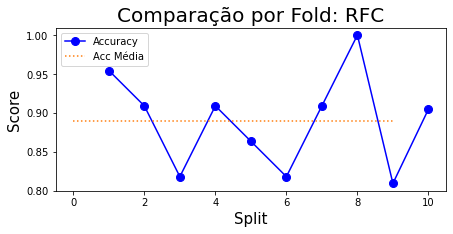

acuraria_calculada= 88.94
recal_calculado =  85.98
precisao_calculado =  91.09


,dataset,qtd_k,modelo,acuracia_media,recall_medio_score,precisao_media_score,ic_acuracia,ic_recall,ic_precisao
0,SFFS_5_CV10,10,RFC,88.96,87.2,92.62,84.5% E 93.43%,82.96% E 91.43%,86.33% E 98.9%


In [4]:
dataset_testado = 'SFFS_5_CV10'
k_qtd = 10

#TESTE BERNOULI
#modelo = 'Bernourlli'
#val_param={'alpha': 0.0, 'binarize': 0.9}


#TESTE Gaussian
#modelo = 'Gaussian'
#val_param={'var_smoothing': 0.0}


# TESTE SVM
#modelo = 'SVM'
#val_param = {'C': 0.8, 'gamma': 'auto', 'kernel': 'linear'}

#TESTE MLP
#modelo = 'MLP'
#val_param={'verbose':0,'max_iter':1000,'tol':0.000010,'activation':'tanh','hidden_layer_sizes':53
#                                                ,'activation':'relu','learning_rate_init':0.01
#                                                ,'hidden_layer_sizes':(100)}

            #modelo_escolhido = MLPClassifier(verbose = 0,max_iter=1000,tol=0.000010
            #                                    ,activation='relu',learning_rate_init =0.01
            #                                    ,hidden_layer_sizes=(100))

#TESTE RFC
modelo = 'RFC'
val_param={'n_estimators':500, 'max_features':18}    
            
            
df_result,mc = Aplica_modelo(dataset_testado,k_qtd,val_param,modelo)
df_result

In [ ]:
mc[9]

### RESULTADOS: NAYVE BAYES

### Verificar arquivo: RESULTADOS/Resultados_Nayve_Bayes.txt

# TESTE TODOS OS ALGORITMOS COM GRIDSEARCH

In [8]:
#############################
#### Rotina de Execução  ####
#############################
def executa(ds):

    #DETERMINA QUAL DATASET A SER UTILZADO
    dataset_testado = ds

    #A QUANTIDADE DE FOLDS QUE IREMOS TESTAR
    k_qtd = 10

    # Separação dos dados
    Separa_dados(dataset_testado,k_qtd)
    df_nb,XX,Y,cv_ = Separa_dados(dataset_testado,k_qtd)


    # LISTA DE PARAMETROS PARA TESTE POR MODELO
    parametros_mods = {
'''                    'svm':{
                        'model':svm.SVC(),
                        'params':{
                            'C':[0.0,0.001,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1,1.5,10,20],
                            'kernel':['rbf','linear','poly','sigmoid'],
                            #'gamma':[0.1,1,10,'auto','scale']
                            'gamma':[0.001,0.0010,0.01886792,0.0019,0.0018,0.0017,0.0016,0.002,0.003,0.005,0.01,0.02,0.03,0.04,0.5,1,10]
                            #,'max_iter':[1,-1]
                        }
                    },
                    'naive_Gauss':{
                        'model':GaussianNB(),
                        'params':{
                            'var_smoothing':[0.0,0.001,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
                        }
                    },  
                    'naive_Bernouli':{
                        'model':BernoulliNB(),
                        'params':{
                            'alpha':[0.0,0.001,0.1,0.2,0.5,1,1.5,10,20],
                            'binarize':[0.0,0.001,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5]
                        }
                    },
                    'MLP':{
                        'model':MLPClassifier(),
                        'params':{
                        'max_iter':[30,60,90,120,150],
                        'activation':['identity','logistic','tanh','relu'],
                        'learning_rate_init':[0.01,0.05,0.1],
                        'hidden_layer_sizes':[8,18,36,53,328]
                        }
                    },
'''                    'RF':{
                        'model':RandomForestClassifier(),
                        'params':{
                        'n_estimators':[500,750,1000,1250,1500],
                        'max_features':[18, 53, 328]
                        }
                    }
                     
                } 

    #i=0
    #metricas=[]

    #LISTA DE SOCRE PARA TESTE
    scoring = {'precision_score': make_scorer(precision_score),'recall_score': make_scorer(recall_score),
            'accuracy_score': make_scorer(accuracy_score)}

    df_metricas_total = None
    metricas=[]
    
    for model_name,mp in parametros_mods.items():
        classificador = GridSearchCV(mp['model'],mp['params'],cv=cv_,return_train_score=True, scoring=scoring, refit='accuracy_score')
        classificador.fit(XX, Y)
        y_pred = classificador.predict(XX)


        #Gera dataframe de todos os resultados obtidos para cada combinação de parametro
        resultados = pd.DataFrame(classificador.cv_results_)

        #Seleciona melhor resultado para o parametro escolido, nesse caso acurácia
        melhor_resultado = resultados.sort_values(by=['rank_test_accuracy_score']).head(1)

        #Guarda as médias dos resultados necessários
        acuracia_media = melhor_resultado['mean_test_accuracy_score']
        mean_test_precision_score = melhor_resultado['mean_test_precision_score']
        mean_test_recall_score = melhor_resultado['mean_test_recall_score']


        #CALCULA INDICE DE CONFIANÇA PARA CADA VALOR DE ACURÁCIA DO MELHOR RESULTADO
        IC_ACC=[]
        IC_REC=[]
        IC_PRES=[]
        TP=0
        TN=0
        FP=0
        FN=0
        vacc=[]
        vrec=[]
        vpres=[]
        for i in range(0,k_qtd):
            vacc.append(melhor_resultado['split' + str(i) + '_test_accuracy_score'].values)
            vrec.append(melhor_resultado['split' + str(i) + '_test_recall_score'].values)
            vpres.append(melhor_resultado['split' + str(i) + '_test_precision_score'].values)

        IC_ACC =sms.DescrStatsW(vacc).tconfint_mean(alpha=0.05)
        IC_REC =sms.DescrStatsW(vrec).tconfint_mean(alpha=0.05)  
        IC_PRES =sms.DescrStatsW(vpres).tconfint_mean(alpha=0.05)     
   

        #DEFINE MATRIZ DE CONFUSÃO
        matriz_confusao = pd.DataFrame(confusion_matrix(Y, y_pred),
                     columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])

        TP = matriz_confusao['pred_neg'][0]
        TN = matriz_confusao['pred_pos'][1]
        FP = matriz_confusao['pred_pos'][0]    
        FN = matriz_confusao['pred_neg'][1]

        #RECALL MÉDIO
        RECALL = round(TP/(TP+FN)*100,2)

        #PRECISÃO MÉDIO
        PRECISAO = round(TP/(TP+FP)*100,2)

        #EXIBE GRÁFICOS
        med=[]
        for i in range(0,k_qtd):
            med.append(float(round(acuracia_media,2)))


        plt.figure(figsize=(7,3))
        plt.plot(vacc, '-bo', label = 'Accuracy', markersize=8)
        plt.plot(med,color='C1',linestyle=':',markersize=12)
        plt.xlabel('Split', fontsize = 15)
        plt.ylabel('Score', fontsize = 15)
        plt.title(f'Comparação por Fold: {dataset_testado} -' +  f' {model_name}', fontsize = 15)
        plt.legend()

        metricas.append({
            'dataset_testado':dataset_testado,
            'modelo': model_name,
            'acuracia_media':f'{round(float(classificador.best_score_)*100,2)}%',
            'melhor_parametro':classificador.best_params_,
            'TP':TP,
            'TN':TN,
            'FP':FP,  
            'FN':FN,
            'RECALL_CALCULADO':RECALL,
            'recall_medio':f'{round(float(mean_test_recall_score)*100,2)}%',
            'PRECISAO_CALCULADA':PRECISAO,
            'precisao_media':f'{round(float(mean_test_precision_score)*100,2)}%',
            'ic_acuracia': f'{round(float(IC_ACC[0])*100,2)}% E {round(float(IC_ACC[1])*100,2)}%',
            'ic_recall': f'{round(float(IC_REC[0])*100,2)}% E {round(float(IC_REC[1])*100,2)}%',
            'ic_precisao': f'{round(float(IC_PRES[0])*100,2)}% E {round(float(IC_PRES[1])*100,2)}%'
        })  



    df_metricas_total = pd.DataFrame(metricas, columns=['dataset_testado','modelo','melhor_parametro','acuracia_media'
                                                        #,'TP','TN','FP','FN','RECALL_CALCULADO','PRECISAO_CALCULADA'
                                                        ,'recall_medio','precisao_media'
                                                        ,'ic_acuracia','ic_recall','ic_precisao'])

    plt.show() 
    
    print('Métricas Total:\n', df_metricas_total)
    print()
    print('Melhor parâmetro:\n', df_metricas_total['melhor_parametro'])
    print()
    print('Matriz de Confusão:\n', matriz_confusao)
    print()
    
    m = TP+TN+FP+FN
    acuracia = round((TP+TN)/(m)*100,2) #acuracia
    acuracia
    print('Acurácia:\n', acuracia)
    print()
    
    #MATRIZ DADA PELO TREINO COM OS MELHORES PARAMETROS
    y_pred = classificador.best_estimator_.predict(XX)
    matriz_nova = confusion_matrix(Y, y_pred)
    print('Matriz Nova:\n', matriz_nova)
    print()
    
    TP_2 = matriz_nova[0][0]
    TN_2 = matriz_nova[1][1]
    FP_2 = matriz_nova[0][1]   
    FN_2 = matriz_nova[1][0]
    m = TP_2+TN_2+FP_2+FN_2
    acuracia_2 = round((TP_2+TN_2)/(m)*100,2) #acuracia
    print('Acurácia 2:\n', acuracia_2)
    print()
    
    print('Acurácia Score:\n', round(accuracy_score(y_pred, Y)*100,2))
    print()
    
    #print('Melhor resultado - Acurácia média:\n', round(float(melhor_resultado['mean_test_accuracy_score'])*100,2))
    print()
        
    #print('Melhor resultado - Recall médio:\n', round(float(melhor_resultado['mean_test_recall_score'])*100,2))
    print()
    
    p=TP+FN
    recall = round(TP/(p)*100,2) #recall
    print('Recall médio:\n', recall)
    print()
    
    PRECISAO = round(TP/(TP+FP)*100,2) #PRECISAO
    print('Precisão:\n', PRECISAO)
    print()
    
    #print('Melhor resultado - Precisão média:\n', round(float(melhor_resultado['mean_test_precision_score'])*100,2))
    print()
    
    resultados = pd.DataFrame(classificador.cv_results_)
    melhor_resultado = resultados.sort_values(by=['rank_test_accuracy_score']).head(1)
    print('Melhor resultado:\n', melhor_resultado)
    print()
    
    print('FN:\n', FN)
    print()
    

In [9]:
##############################
#### Rotina de Resultados ####
##############################
def resultados(df_metricas_total, matriz_confusao, TP, TN, FP, FN, XX, Y):
    print('Métricas Total:\n', df_metricas_total)
    print()
    print('Melhor parâmetro:\n', df_metricas_total['melhor_parametro'])
    print()
    print('Matriz de Confusão:\n', matriz_confusao)
    print()
    
    m = TP+TN+FP+FN
    acuracia = round((TP+TN)/(m)*100,2) #acuracia
    acuracia
    print('Acurácia:\n', acuracia)
    print()
    
    #MATRIZ DADA PELO TREINO COM OS MELHORES PARAMETROS
    y_pred = classificador.best_estimator_.predict(XX)
    matriz_nova = confusion_matrix(Y, y_pred)
    print('Matriz Nova:\n', matriz_nova)
    print()
    
    TP_2 = matriz_nova[0][0]
    TN_2 = matriz_nova[1][1]
    FP_2 = matriz_nova[0][1]   
    FN_2 = matriz_nova[1][0]
    m = TP_2+TN_2+FP_2+FN_2
    acuracia_2 = round((TP_2+TN_2)/(m)*100,2) #acuracia
    print('Acurácia 2:\n', acuracia_2)
    print()
    
    print('Acurácia Score:\n', round(accuracy_score(y_pred, Y)*100,2))
    print()
    
    #print('Melhor resultado - Acurácia média:\n', round(float(melhor_resultado['mean_test_accuracy_score'])*100,2))
    print()
        
    #print('Melhor resultado - Recall médio:\n', round(float(melhor_resultado['mean_test_recall_score'])*100,2))
    print()
    
    p=TP+FN
    recall = round(TP/(p)*100,2) #recall
    print('Recall médio:\n', recall)
    print()
    
    PRECISAO = round(TP/(TP+FP)*100,2) #PRECISAO
    print('Precisão:\n', PRECISAO)
    print()
    
    #print('Melhor resultado - Precisão média:\n', round(float(melhor_resultado['mean_test_precision_score'])*100,2))
    print()
    
    resultados = pd.DataFrame(classificador.cv_results_)
    melhor_resultado = resultados.sort_values(by=['rank_test_accuracy_score']).head(1)
    print('Melhor resultado:\n', melhor_resultado)
    print()
    
    print('FN:\n', FN)
    print()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anaco

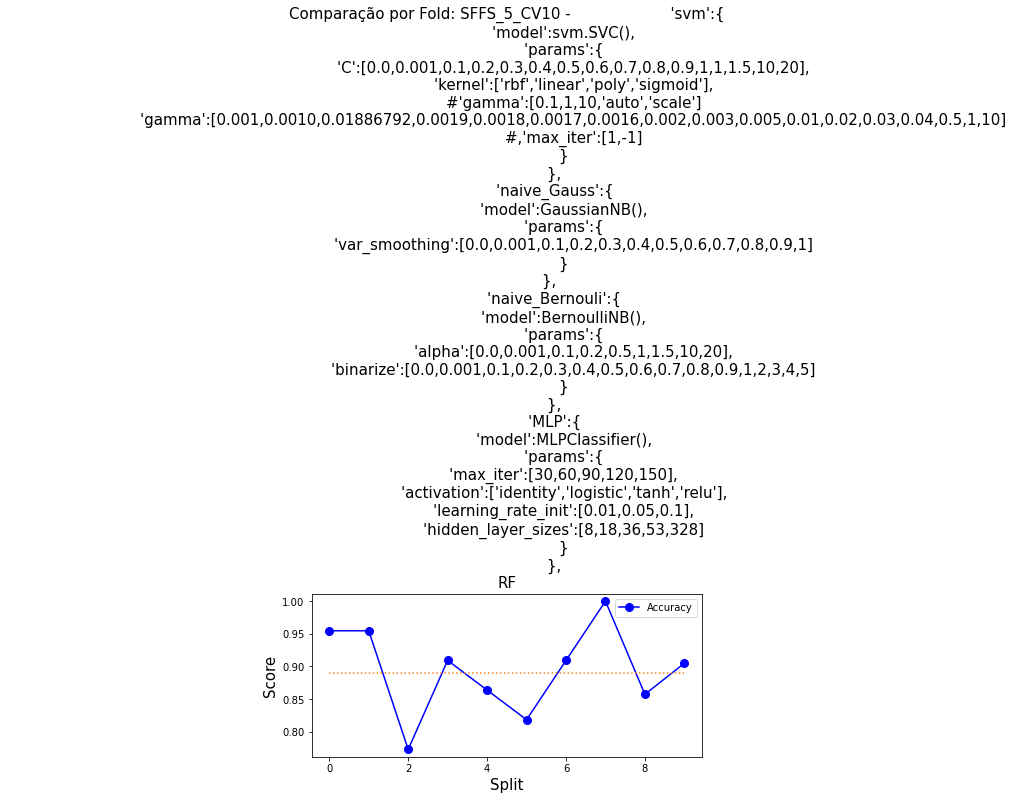

Métricas Total:
   dataset_testado                                             modelo  \
0     SFFS_5_CV10                      'svm':{\n                 ...   

                            melhor_parametro acuracia_media recall_medio  \
0  {'max_features': 18, 'n_estimators': 750}         89.44%       88.03%   

  precisao_media      ic_acuracia        ic_recall     ic_precisao  
0         92.62%  84.56% E 94.32%  83.81% E 92.25%  86.33% E 98.9%  

Melhor parâmetro:
 0    {'max_features': 18, 'n_estimators': 750}
Name: melhor_parametro, dtype: object

Matriz de Confusão:
      pred_neg  pred_pos
neg       101         0
pos         0       116

Acurácia:
 100.0

Matriz Nova:
 [[101   0]
 [  0 116]]

Acurácia 2:
 100.0

Acurácia Score:
 100.0



Recall médio:
 100.0

Precisão:
 100.0


Melhor resultado:
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1       1.337776       0.08534         0.059917        0.006728   

  param_max_features param_n_estimators  \
1      

In [10]:
##########################
#### Rotina Principal ####
##########################

# Dataset a ser utilizado
dataset_testado = ['SFFS_5_CV10']
'''                'COMPLETO',
                   'PCA',
                   'PCA_IMPORTANCES',
                   'KBEST',
                   'KBEST_2',
                   'RFE',
                   'RANDON_FOREST_IMPORTANTES',
                   'SBS',
                   'KBEST_S_IDADE',
                   'SFS_5_CV10',
                   'SFS_15_CV00',
                   'SFS_15_CV10',
                   'SFS_30_CV00',
                   'SFS_90_CV00',
                   'SFS_180_CV00',
                   'SFS_180_CV10',
                   'SFFS_5_CV10',
                   'SFFS_15_CV00',
                   'SFFS_15_CV10',
                   'SFFS_30_CV00',
                   'SFFS_30_CV10',
                   'SFFS_90_CV00',
                   'SFFS_90_CV10'] '''

for d in dataset_testado:
    executa(d)